In [1]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.featexpl import FeaturesExplanation
from machinelearning.explorexplain import ExploreExplain

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier

csv_dir = 'data/EPIC_norm_pos.txt'
# csv_dir = 'data/composite_dataset.csv'
label = 'group'

# model = LogisticRegression()

%load_ext autoreload
%autoreload 2

# %matplotlib inline


In [2]:
# dataloader
mlpipe = MLPipelines(label=label, csv_dir=csv_dir)
# mlpipe = MLPipelines(label=label, csv_dir=csv_dir, estimator=CatBoostClassifier())

# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', num_features=20, inner_method='chi2')

mlpipe.X=mlpipe.X.fillna(0)

Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}
There is no selected classifier.


### Running tests

**Dynamic Parallel**

Outer fold of 4 round:: 100%|██████████| 3/3 [02:05<00:00, 41.93s/it]


Finished with 4 round after 0.03 hours.


Outer fold of 2 round:: 100%|██████████| 3/3 [02:06<00:00, 42.31s/it]


Finished with 2 round after 0.04 hours.


Outer fold of 3 round:: 100%|██████████| 3/3 [02:22<00:00, 47.53s/it]


Finished with 3 round after 0.04 hours.


Outer fold of 1 round:: 100%|██████████| 3/3 [02:34<00:00, 51.49s/it]


Finished with 1 round after 0.04 hours.
Finished with 12 estimators
No features were selected.


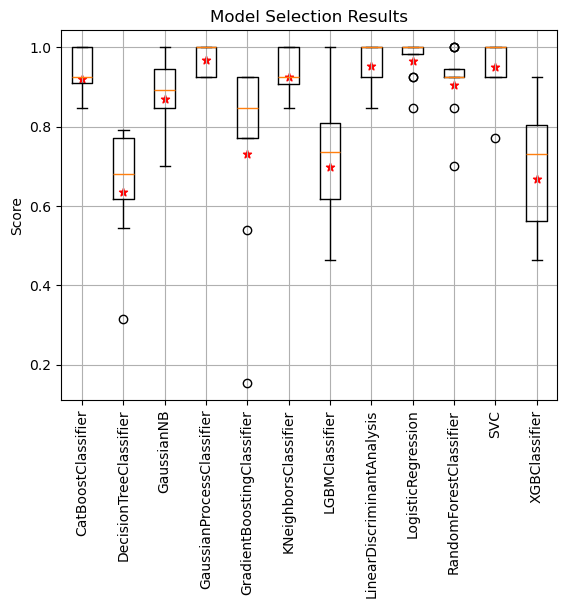

  0%|          | 0/50 [00:00<?, ?it/s]

For the GaussianProcessClassifier model: 
Best parameters: {'optimizer': 'fmin_l_bfgs_b', 'max_iter_predict': 927, 'warm_start': False}
Best matthews_corrcoef: 0.9745743121887939


In [6]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=20,n_trials=50,rounds=4,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=3,inner_splits=3,hist_fit=True,parallel='dynamic_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

**Freely Parallel**

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round: 33% |████▎        | Elapsed Time: 0:00:41 ETA:   0:01:23
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:00:45 ETA:   0:01:31
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:00:54 ETA:   0:01:48
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:00:53 ETA:   0:01:47
Outer fold of 4 round: 66% |████████▋    | Elapsed Time: 0:01:17 ETA:   0:00:38
Outer fold of 4 round:100% |█████████████| Elapsed Time: 0:01:18 Time:  0:01:18


Finished with 4 round after 0.03 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:01:25 ETA:   0:00:42
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:01:26 Time:  0:01:26


Finished with 2 round after 0.04 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:01:39 ETA:   0:00:49
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:01:40 Time:  0:01:40


Finished with 1 round after 0.04 hours.


Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:01:34 ETA:   0:00:47


Finished with 3 round after 0.04 hours.
Finished with 12 estimators
No features were selected.


Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:01:35 Time:  0:01:35


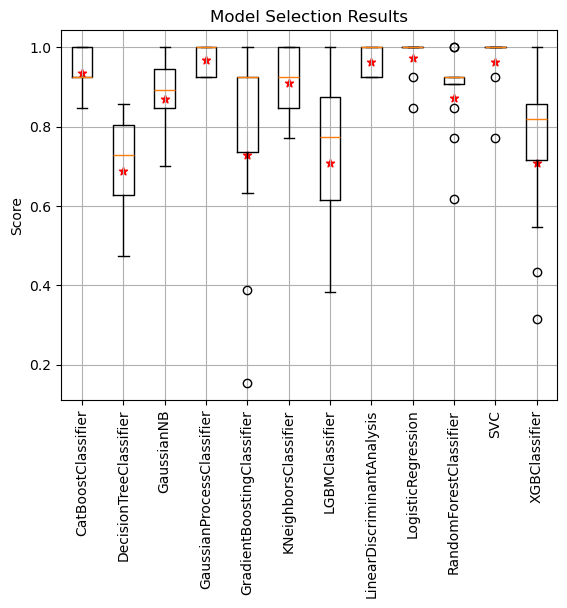

  0%|          | 0/50 [00:00<?, ?it/s]

For the LogisticRegression model: 
Best parameters: {'penalty': 'l2', 'C': 3.73122665695744, 'solver_2': 'newton-cg', 'max_iter': 654, 'fit_intercept': False}
Best matthews_corrcoef: 1.0


In [7]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=20,n_trials=50,rounds=4,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=3,inner_splits=3,hist_fit=True,parallel='freely_parallel')#exclude=[LGBMClassifier()])# search_on=[LinearDiscriminantAnalysis(),LogisticRegression()])#exclude=[LGBMClassifier()])

**Thread per Round**

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


  0% |                                   | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% |                                   | Elapsed Time: 0:00:00 ETA:  --:--:--
 33% |███████████▋                       | Elapsed Time: 0:00:32 ETA:   0:01:04
 33% |███████████▋                       | Elapsed Time: 0:00:59 ETA:   0:01:58
 66% |███████████████████████▎           | Elapsed Time: 0:01:15 ETA:   0:00:37
100% |███████████████████████████████████| Elapsed Time: 0:01:16 Time:  0:01:16


Finished with 2 round after 0.03 hours.


 66% |███████████████████████▎           | Elapsed Time: 0:01:30 ETA:   0:00:45
100% |███████████████████████████████████| Elapsed Time: 0:01:31 Time:  0:01:31


Finished with 1 round after 0.03 hours.
Finished with 12 estimators
No features were selected.


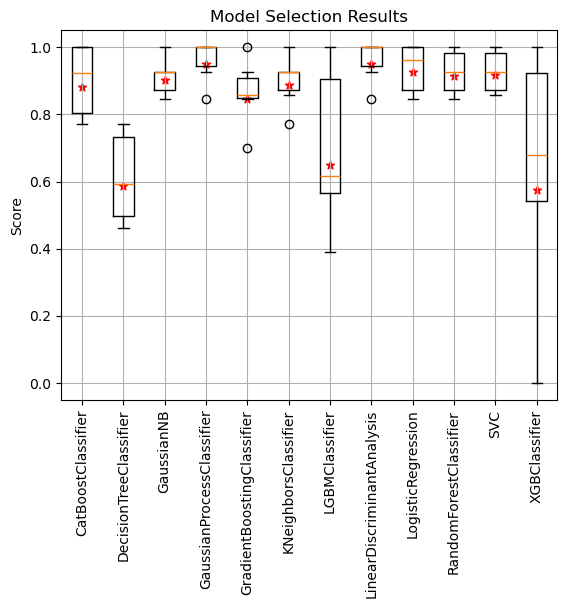

  0%|          | 0/50 [00:00<?, ?it/s]

For the GaussianProcessClassifier model: 
Best parameters: {'optimizer': None, 'max_iter_predict': 476, 'warm_start': True}
Best matthews_corrcoef: 0.9763834207376394


In [ ]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=50,rounds=4,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=3,inner_splits=3,hist_fit=True,parallel='thread_per_round')

### Final models tests

In [13]:
for estim_name, estimator in mlpipe.available_clfs.items():
    print(f'starting with {estim_name} estimator:')
    mlpipe.bayesian_search(estimator_name=estim_name,n_trials=20)
    

starting with RandomForestClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the RandomForestClassifier model: 
Best parameters: {'n_estimators': 192, 'criterion': 'entropy', 'max_depth': 38, 'min_samples_leaf': 6, 'min_samples_split': 8, 'bootstrap': True}
Best matthews_corrcoef: 0.9745743121887939
starting with GradientBoostingClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GradientBoostingClassifier model: 
Best parameters: {'loss': 'exponential', 'learning_rate': 0.4494345819629938, 'n_estimators': 98, 'criterion': 'friedman_mse', 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 10}
Best matthews_corrcoef: 0.9294936460370906
starting with LinearDiscriminantAnalysis estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LinearDiscriminantAnalysis model: 
Best parameters: {'solver': 'eigen', 'shrinkage': 0.4461534282970653, 'tol': 0.001}
Best matthews_corrcoef: 0.9745743121887939
starting with LogisticRegression estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LogisticRegression model: 
Best parameters: {'penalty': None, 'C': 1.816119056747756, 'solver_3': 'saga', 'max_iter': 147, 'fit_intercept': True}
Best matthews_corrcoef: 1.0
starting with XGBClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the XGBClassifier model: 
Best parameters: {'learning_rate': 0.19262179037371452, 'n_estimators': 354, 'max_depth': 26, 'min_child_weight': 1, 'gamma': 0.31345255398107563, 'subsample': 0.21093926162313856, 'colsample_bytree': 0.17351494527066114, 'reg_alpha': 0.18335424266311406, 'reg_lambda': 0.2167130462675442, 'scale_pos_weight': 1.2676008461117587, 'booster': 'gbtree', 'tree_method': 'hist'}
Best matthews_corrcoef: 0.8978119921662108
starting with GaussianNB estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GaussianNB model: 
Best parameters: {'var_smoothing': 3.052177621492348e-06}
Best matthews_corrcoef: 0.8724167290983139
starting with KNeighborsClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the KNeighborsClassifier model: 
Best parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1, 'leaf_size': 43}
Best matthews_corrcoef: 1.0
starting with DecisionTreeClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the DecisionTreeClassifier model: 
Best parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 84, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.15328496637928715}
Best matthews_corrcoef: 0.7524353394314943
starting with SVC estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the SVC model: 
Best parameters: {'C': 3, 'kernel': 'linear', 'probability': True, 'shrinking': False, 'decision_function_shape': 'ovo'}
Best matthews_corrcoef: 1.0
starting with LGBMClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LGBMClassifier model: 
Best parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'learning_rate': 0.1530943257510845, 'n_estimators': 178, 'subsample_for_bin': 173123, 'min_split_gain': 0.19017144959076915, 'bagging_fraction': 0.365776819319762, 'feature_fraction': 0.33713320960361615}
Best matthews_corrcoef: 0.8773411536640726
starting with GaussianProcessClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GaussianProcessClassifier model: 
Best parameters: {'optimizer': None, 'max_iter_predict': 592, 'warm_start': False}
Best matthews_corrcoef: 0.9745743121887939
starting with CatBoostClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the CatBoostClassifier model: 
Best parameters: {'iterations': 71, 'learning_rate': 0.04104964779213016, 'depth': 12, 'l2_leaf_reg': 9.746506127024131e-08, 'border_count': 130, 'bagging_temperature': 6.2554042383732025, 'random_strength': 6.747011493395981, 'leaf_estimation_method': 'Gradient', 'model_size_reg': 0.10287480499540248, 'rsm': 0.10390339554915104, 'loss_function': None}
Best matthews_corrcoef: 1.0


### Feature selection

**Check general option**

starting with RandomForestClassifier estimator:
Shape of the SHAP values: (78, 200, 2) for RandomForestClassifier estimator


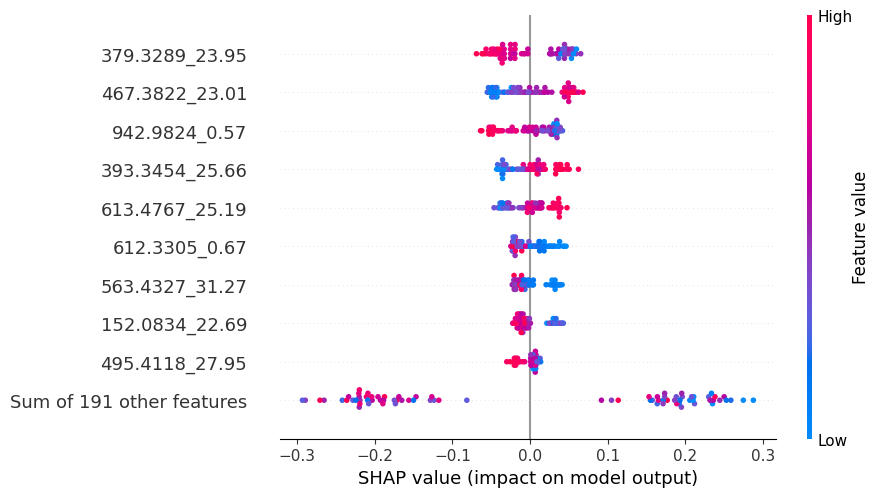

The plot is for label 1, corresponding to Factor1:CONTROL
starting with GradientBoostingClassifier estimator:
Shape of the SHAP values: (78, 200) for GradientBoostingClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


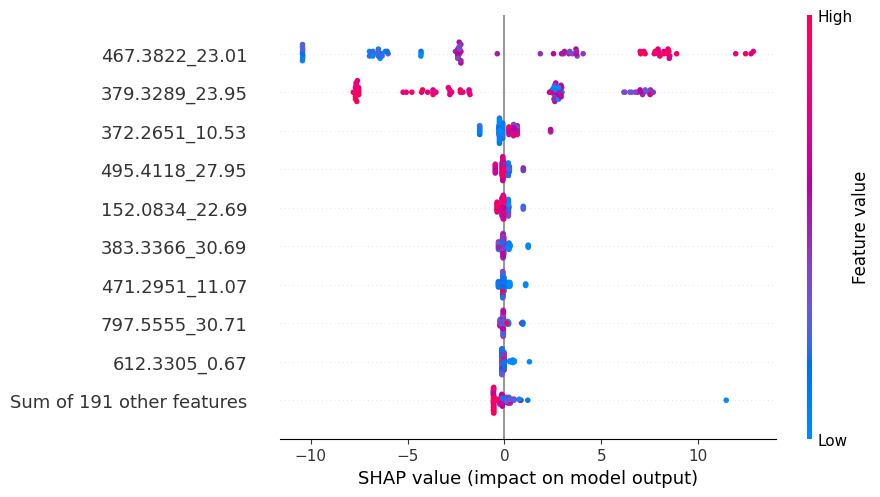

starting with LinearDiscriminantAnalysis estimator:
Shape of the SHAP values: (78, 200) for LinearDiscriminantAnalysis estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


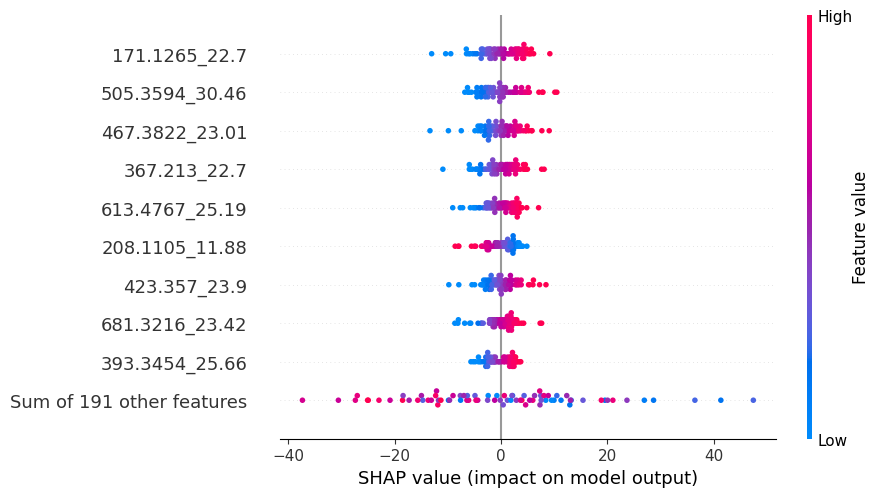

starting with LogisticRegression estimator:
Shape of the SHAP values: (78, 200) for LogisticRegression estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


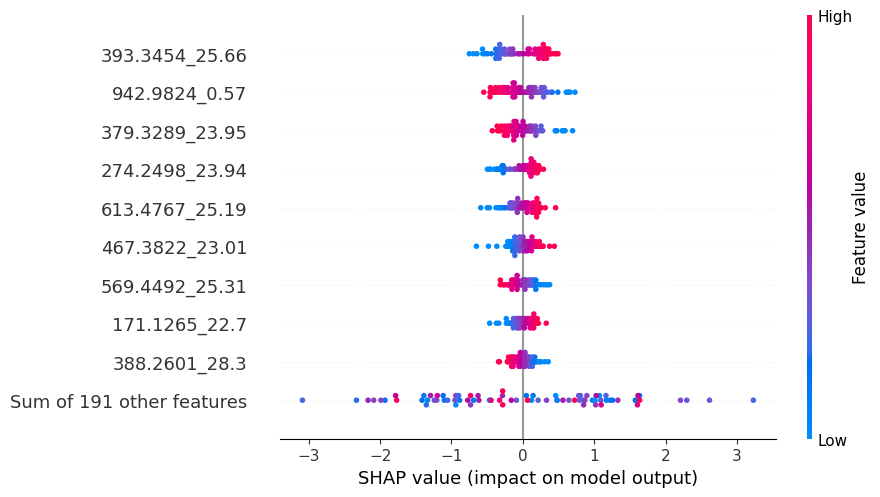

starting with XGBClassifier estimator:
Shape of the SHAP values: (78, 200) for XGBClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


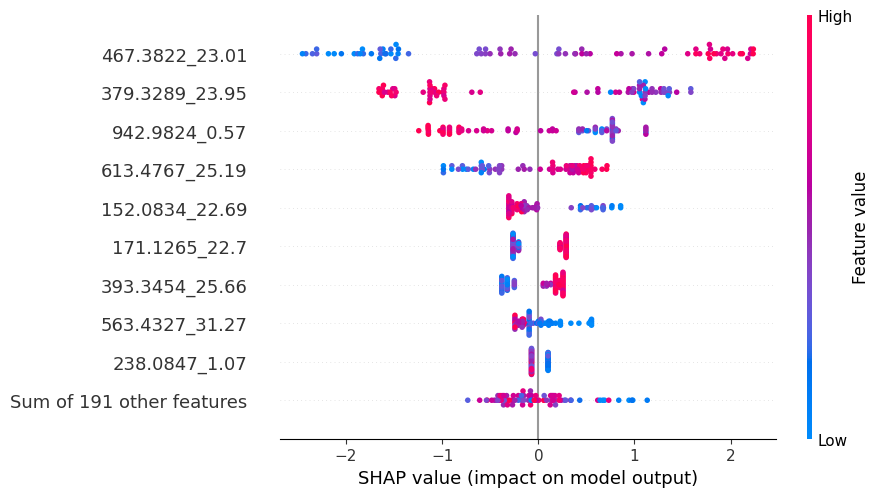

starting with GaussianNB estimator:
Switching to predict_proba due to compatibility issue with the model.


PermutationExplainer explainer: 79it [00:10,  2.11s/it]                        


Shape of the SHAP values: (78, 200, 2) for GaussianNB estimator


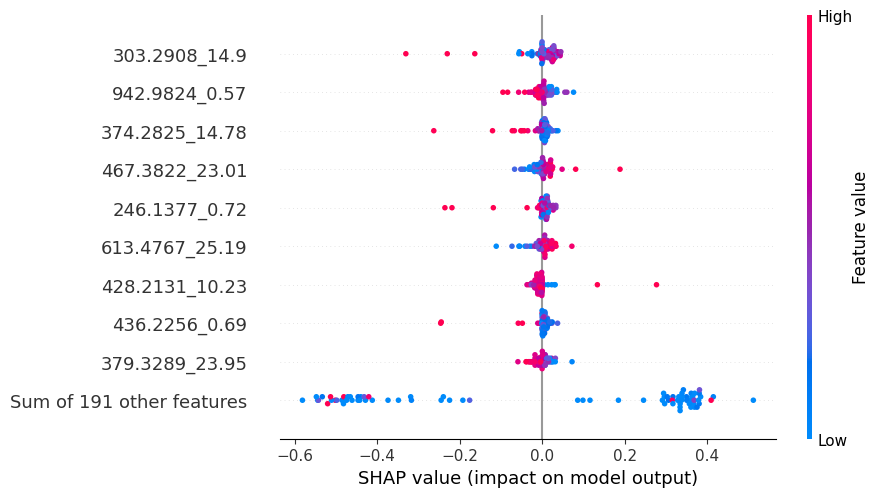

The plot is for label 1, corresponding to Factor1:CONTROL
starting with KNeighborsClassifier estimator:
Switching to predict_proba due to compatibility issue with the model.
Shape of the SHAP values: (78, 200, 2) for KNeighborsClassifier estimator


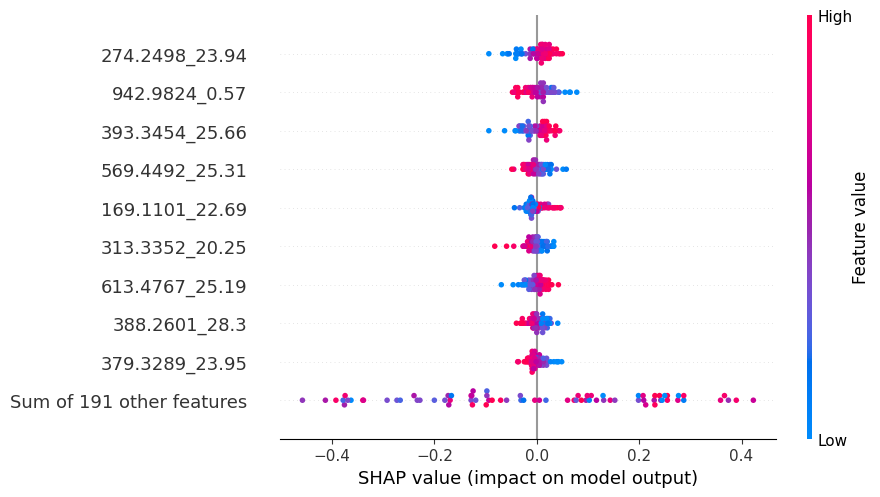

The plot is for label 1, corresponding to Factor1:CONTROL
starting with DecisionTreeClassifier estimator:
Shape of the SHAP values: (78, 200, 2) for DecisionTreeClassifier estimator


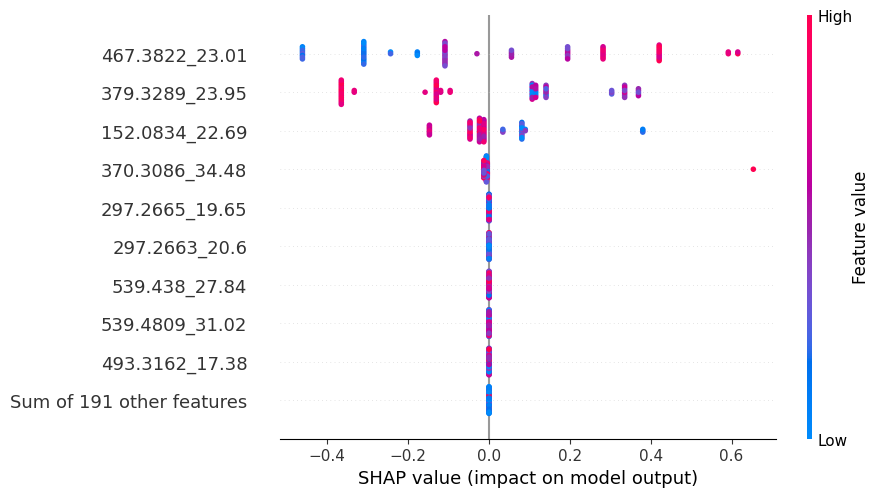

The plot is for label 1, corresponding to Factor1:CONTROL
starting with SVC estimator:
Switching to predict_proba due to compatibility issue with the model.


PermutationExplainer explainer: 79it [00:29,  1.79it/s]                        

Shape of the SHAP values: (78, 200, 2) for SVC estimator


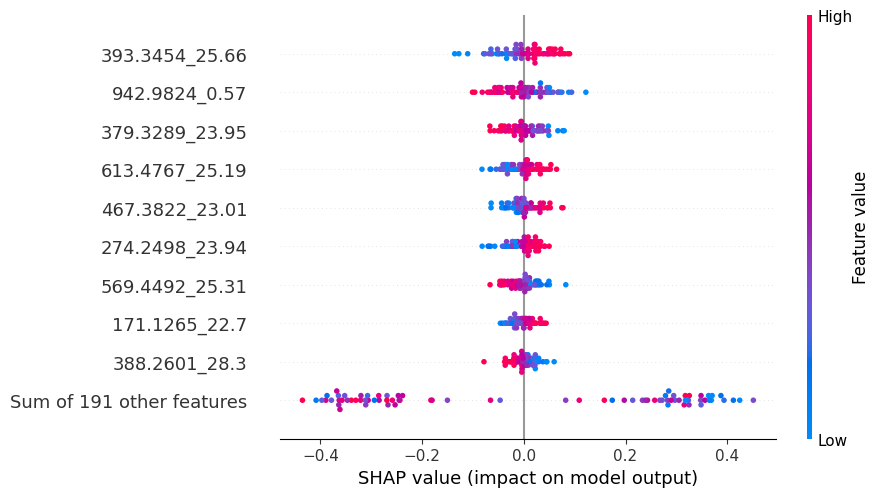

The plot is for label 1, corresponding to Factor1:CONTROL
starting with LGBMClassifier estimator:
[LightGBM] [Info] Number of positive: 39, number of negative: 39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5396
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

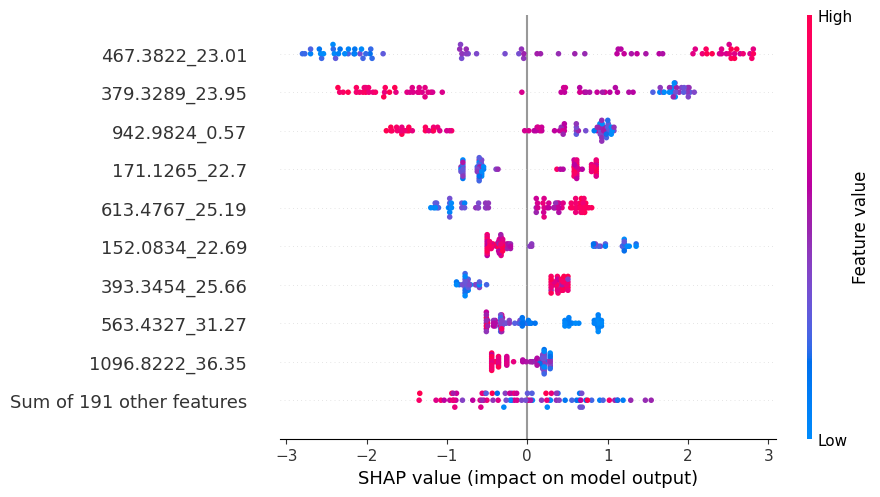

starting with GaussianProcessClassifier estimator:
Switching to predict_proba due to compatibility issue with the model.


PermutationExplainer explainer: 79it [00:46,  1.30it/s]                        

Shape of the SHAP values: (78, 200, 2) for GaussianProcessClassifier estimator


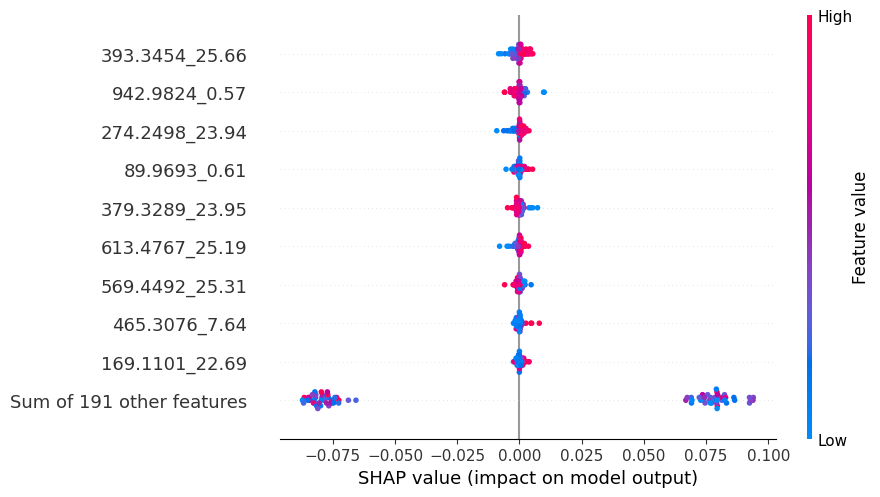

The plot is for label 1, corresponding to Factor1:CONTROL
starting with CatBoostClassifier estimator:
Learning rate set to 0.003466
0:	learn: 0.6902811	total: 54ms	remaining: 54s
1:	learn: 0.6877772	total: 58.5ms	remaining: 29.2s
2:	learn: 0.6854175	total: 63ms	remaining: 20.9s
3:	learn: 0.6828346	total: 68.1ms	remaining: 17s
4:	learn: 0.6802006	total: 73.1ms	remaining: 14.6s
5:	learn: 0.6776694	total: 78ms	remaining: 12.9s
6:	learn: 0.6749564	total: 83.3ms	remaining: 11.8s
7:	learn: 0.6722384	total: 88ms	remaining: 10.9s
8:	learn: 0.6693699	total: 93ms	remaining: 10.2s
9:	learn: 0.6667924	total: 98.6ms	remaining: 9.76s
10:	learn: 0.6642034	total: 104ms	remaining: 9.35s
11:	learn: 0.6625191	total: 110ms	remaining: 9.03s
12:	learn: 0.6601061	total: 115ms	remaining: 8.7s
13:	learn: 0.6576009	total: 119ms	remaining: 8.39s
14:	learn: 0.6544025	total: 123ms	remaining: 8.09s
15:	learn: 0.6521877	total: 127ms	remaining: 7.83s
16:	learn: 0.6491027	total: 131ms	remaining: 7.58s
17:	learn: 0.646

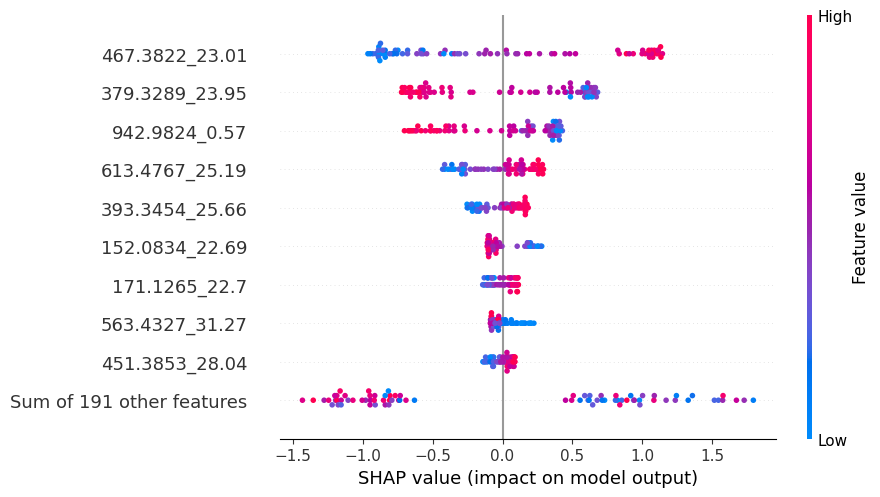

In [3]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name is not 'SVC':
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='general')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = SVC(probability=True).fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='general')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)
        

**Check tree option**

starting with RandomForestClassifier estimator:
Shape of the SHAP values: (78, 200, 2) for RandomForestClassifier estimator


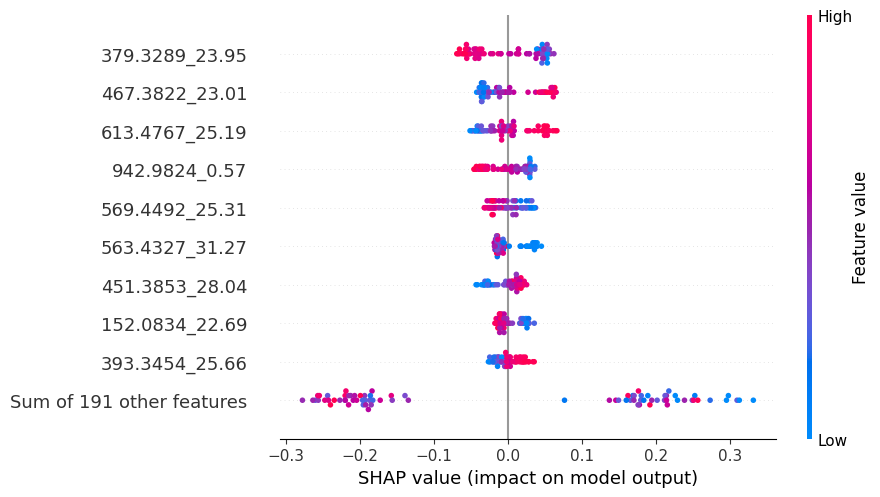

The plot is for label 1, corresponding to Factor1:CONTROL
starting with XGBClassifier estimator:
Shape of the SHAP values: (78, 200) for XGBClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


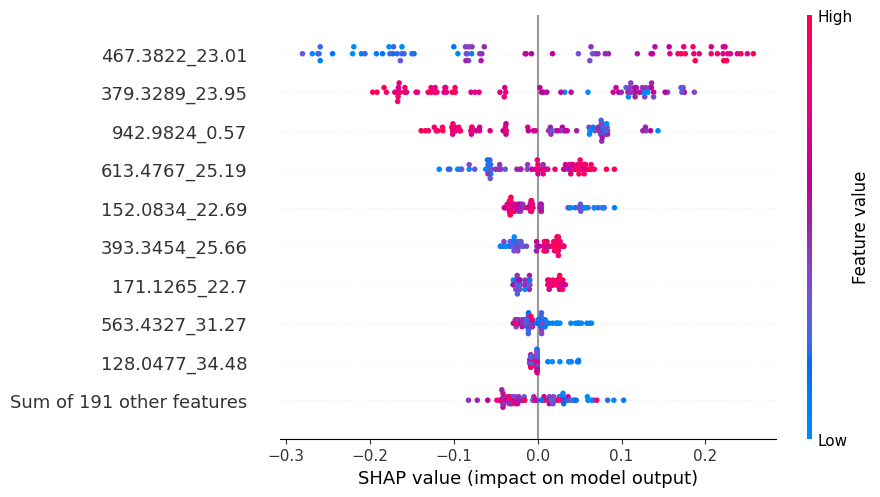

starting with DecisionTreeClassifier estimator:
Shape of the SHAP values: (78, 200, 2) for DecisionTreeClassifier estimator


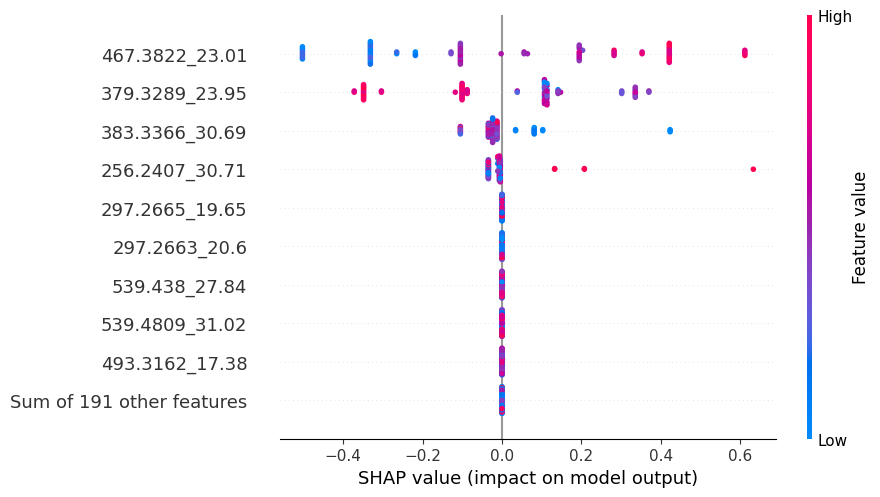

The plot is for label 1, corresponding to Factor1:CONTROL
starting with CatBoostClassifier estimator:
Learning rate set to 0.003466
0:	learn: 0.6902811	total: 1.85ms	remaining: 1.85s
1:	learn: 0.6877772	total: 3.33ms	remaining: 1.66s
2:	learn: 0.6854175	total: 4.7ms	remaining: 1.56s
3:	learn: 0.6828346	total: 6.13ms	remaining: 1.53s
4:	learn: 0.6802006	total: 7.54ms	remaining: 1.5s
5:	learn: 0.6776694	total: 8.96ms	remaining: 1.48s
6:	learn: 0.6749564	total: 10.4ms	remaining: 1.48s
7:	learn: 0.6722384	total: 12.2ms	remaining: 1.52s
8:	learn: 0.6693699	total: 13.9ms	remaining: 1.53s
9:	learn: 0.6667924	total: 15.6ms	remaining: 1.55s
10:	learn: 0.6642034	total: 17.3ms	remaining: 1.55s
11:	learn: 0.6625191	total: 18.8ms	remaining: 1.55s
12:	learn: 0.6601061	total: 20.2ms	remaining: 1.53s
13:	learn: 0.6576009	total: 21.8ms	remaining: 1.54s
14:	learn: 0.6544025	total: 23.6ms	remaining: 1.55s
15:	learn: 0.6521877	total: 25ms	remaining: 1.54s
16:	learn: 0.6491027	total: 26.5ms	remaining: 1.53

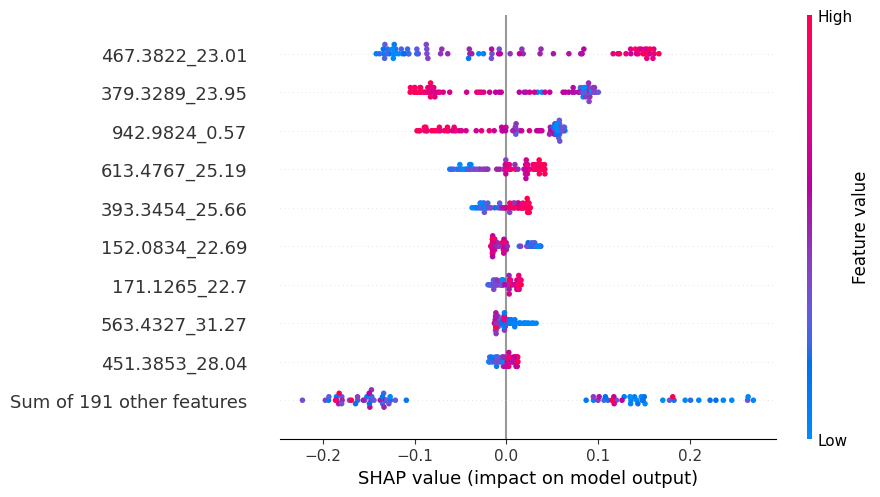

In [17]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name not in ['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier','CatBoostClassifier','LightGBMClassifier']:continue
    elif estim_name == 'XGBClassifier':
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = XGBClassifier(booster='gbtree').fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='tree')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='tree')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)

**Check the linear option**

starting with LinearDiscriminantAnalysis estimator:
Shape of the SHAP values: (78, 200) for LinearDiscriminantAnalysis estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


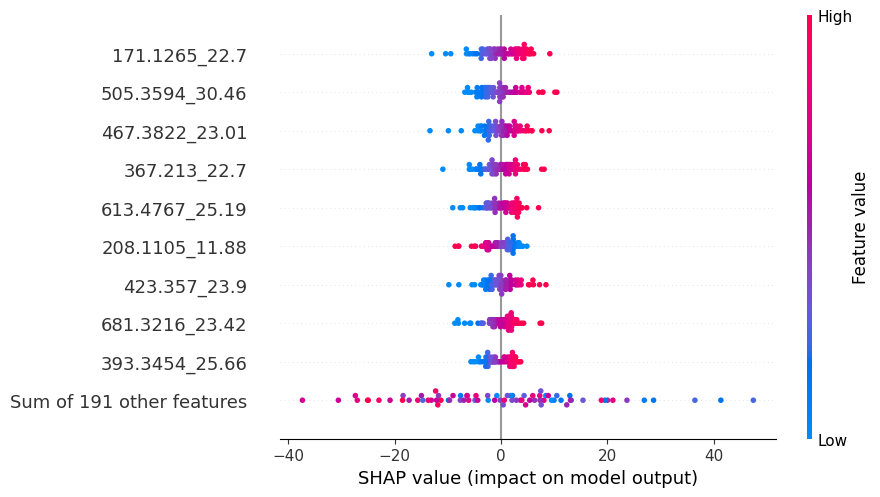

starting with LogisticRegression estimator:
Shape of the SHAP values: (78, 200) for LogisticRegression estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


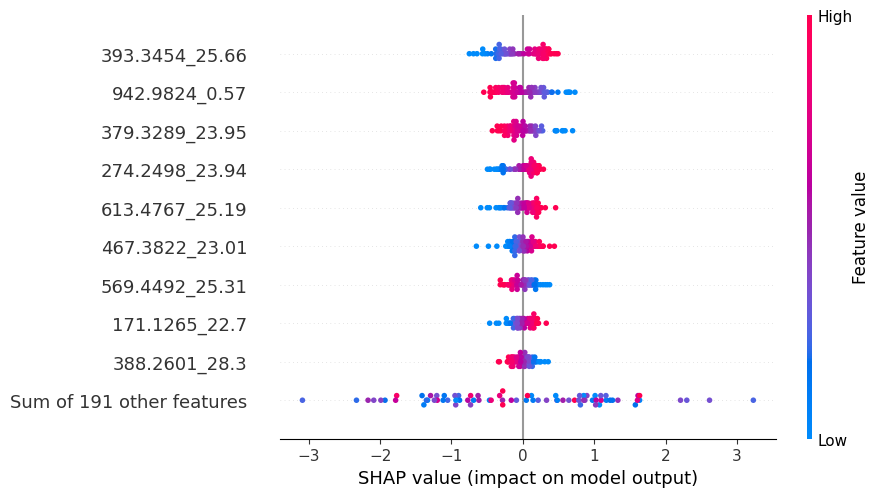

In [18]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name not in ['LogisticRegression', 'LinearDiscriminantAnalysis']:continue
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='linear')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)

### Explainability

**int PCA**

In [32]:
# if __name__ == '__main__':
explore = ExploreExplain(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping, shap_values=fesel.shap_values.values, explainer=fesel.explainer,max_pca=5)
explore.run_server()

In [46]:
explore.create_interactive_pca_plot( n_components = 5, components=(0, 1),top_n_features=10)


FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888

In [52]:
fesel.shap_values.values

array([[-0.38469295, -0.01836951,  0.04721795, ..., -0.00807175,
        -0.00506832, -0.00396822],
       [-0.47149721, -0.0074425 ,  0.0720573 , ..., -0.00696817,
        -0.00349263, -0.00208721],
       [-0.65896792, -0.00530387,  0.04691367, ..., -0.00334264,
        -0.00542308, -0.00492794],
       ...,
       [ 0.39534618,  0.00191326,  0.0202063 , ...,  0.00126525,
         0.0025304 ,  0.00437938],
       [ 0.40282136,  0.00231016,  0.14661677, ...,  0.0116305 ,
         0.00085436,  0.00664095],
       [ 0.09283673,  0.0057682 ,  0.23174899, ...,  0.00233226,
         0.00203122, -0.00266291]])

In [31]:
# def create_pca_dataframe(X, n_components):
#     """
#     Performs PCA on the given dataset X and returns a DataFrame with the principal components.

#     Parameters:
#     - X: array-like, shape (n_samples, n_features)
#         The input data to perform PCA on.
#     - n_components: int
#         The number of principal components to compute.

#     Returns:
#     - df_pca: pandas.DataFrame
#         DataFrame containing the principal components.
#     """
#     pca = PCA(n_components=n_components)
#     components = pca.fit_transform(X)
#     component_names = [f'PC{i+1}' for i in range(n_components)]
#     df_pca = pd.DataFrame(components, columns=component_names)
#     return df_pca

df_pca = create_pca_dataframe(fesel.X, 2)

# mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)

# fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
#                     specs=[[{'type': 'scatter'}, {'type': 'bar'}]])

# scatter = go.Scatter(x=df_pca['PC1'], y=df_pca['PC2'], mode='markers', name='Data Points',
#                      marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))

# bar = go.Bar(x=[f'Feature {i}' for i in range(len(mean_shap_values))], y=mean_shap_values)

# fig.add_trace(scatter, row=1, col=1)
# fig.add_trace(bar, row=1, col=2)

# fig.update_layout(showlegend=False, width=1000, height=500, clickmode='event+select')

# fig_widget = go.FigureWidget(fig)

# def update_shap_plot(trace, points, state):
#     if points.point_inds:
#         idx = points.point_inds[0]  
#         shap_values_point = fesel.shap_values.values[idx]  
#         with fig_widget.batch_update():
#             fig_widget.data[1].y = shap_values_point

# fig_widget.data[0].on_click(update_shap_plot)
# display(fig_widget)


In [22]:
fesel.y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
def create_interactive_pca_shap_plot(df_pca, X, components, image_size=(1000, 500),top_n_features=20):
    """
    Creates an interactive plot with PCA on one side and SHAP values on the other.

    Parameters:
    - df_pca: DataFrame containing PCA components.
    - X: The original dataset used for PCA and SHAP value calculation.
    - components: Tuple of indices for the PCA components to plot, e.g., (0, 1) for PC1 vs. PC2.
    - image_size: Tuple for the image size, default to (1000, 500).

    Returns:
    - A Plotly FigureWidget with interactive capabilities in a Jupyter environment.
    """
    pc_x, pc_y = f'PC{components[0]+1}', f'PC{components[1]+1}'
    
    mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)
    top_indices = mean_shap_values.argsort()[-top_n_features:][::-1]  # Indices of top features
    top_mean_shap_values = mean_shap_values[top_indices]

    fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
                        specs=[[{'type': 'scatter'}, {'type': 'bar'}]],
                        horizontal_spacing=0.1)
    
    scatter = go.Scatter(x=df_pca[pc_x], y=df_pca[pc_y], mode='markers', name='Data Points',
                         marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))
    fig.add_trace(scatter, row=1, col=1)

    bar = go.Bar(x=[f'Feature {i}' for i in top_indices], y=top_mean_shap_values)
    fig.add_trace(bar, row=1, col=2)

    fig.update_layout(showlegend=False, width=image_size[0], height=image_size[1], clickmode='event+select')

    # Convert to FigureWidget for interactivity in Jupyter
    fig_widget = go.FigureWidget(fig)

    # Define callback function for updates
    def update_shap_plot(trace, points, selector):
        if points.point_inds:
            idx = points.point_inds[0]  
            shap_values_point = fesel.shap_values.values[idx][top_indices]  
            with fig_widget.batch_update():
                fig_widget.data[1].y = shap_values_point

    fig_widget.data[0].on_click(update_shap_plot)

    return fig_widget

In [12]:
create_interactive_pca_shap_plot(df_pca, fesel.X, (0, 1), image_size=(1200, 800),top_n_features=100)

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888